In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('purity.csv')
df.atom_list = df.atom_list.apply(lambda x: list(map(int, x.split(','))))
atom_dict = {
    12: 'Mg',
    13: 'Al',
    20: 'Ca',
    22: 'Ti',
    23: 'V',
    24: 'Cr',
    25: 'Mn',
    26: 'Fe',
    27: 'Co',
    28: 'Ni',
    29: 'Cu',
    30: 'Zn',
    38: 'Sr',
    56: 'Ba',
}
for an, name in atom_dict.items():
    df[name] = df.atom_list.apply(lambda x: x.count(an) / len(x))
X = df[atom_dict.values()]
y = df.purity

In [2]:
X

,Mg,Al,Ca,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Sr,Ba
0,0.2,0.2,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.2,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2,0.2,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.0,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.0,0.1,0.1,0.1,0.1
510,0.0,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.1
511,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.0
512,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.1


In [3]:
y.value_counts()
# 0 is non single-phase
# 1 is unconfident
# 2 is single-phase

0    409
2     82
1     23
Name: purity, dtype: int64

# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=100)

10-fold cross validation

In [5]:
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=10)
#for i in range(10):
#    result = np.r_[result, cross_val_score(clf, X, y, cv=10)]
print(np.mean(result), np.std(result))

0.8229260935143288 0.025361240827793806


SHAP analysis

/home/xiangyan/apps/miniconda3/envs/hes_3.6/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


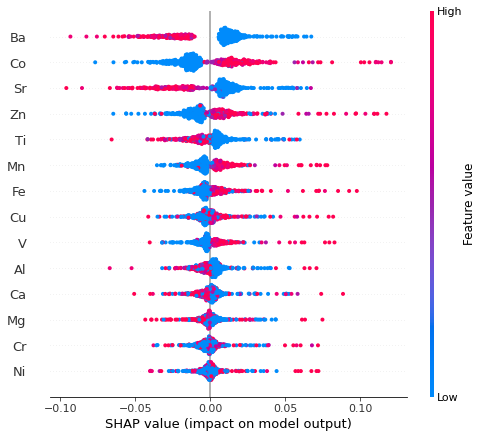

In [6]:
import shap
shap.initjs()
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values[1], X)
    return explainer, shap_values
clf.fit(X, y)
explainer, shap_values = shap_ana(clf, X, y)

(array([161.80066158,   0.        ,  57.52912412,   0.        ,
          0.        ,  28.04544801,   0.        ,   0.        ,
         15.82050913,   0.        ,   0.        ,  12.22493888,
          0.        ,   0.        ,   5.03379836,   0.        ,
          0.        ,   5.75291241,   0.        ,   0.        ,
          2.15734215,   0.        ,   0.        ,   1.4382281 ,
          0.        ,   0.        ,   0.71911405,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          1.4382281 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          1.4382281 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.71911405]),
 array([-0.0444358, -0.0410358, -0.0376358, -0.0342358, -0.0308358,
        -0.0274358, -0.0240358, -0.0206358, -0.0172358, -0.0138358,
        -0.0104358, -0.0070358, -0.0036358, -0.0002358,  0

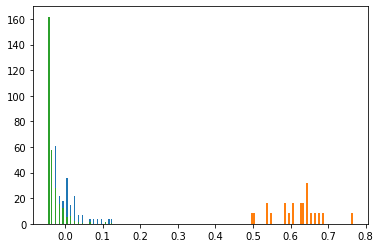

In [7]:
import matplotlib.pyplot as plt
plt.hist(shap_values[1][y == 2].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 0].sum(axis=1), bins=50, density=True)

# XGboost

In [8]:
from xgboost import XGBRFClassifier
clf = XGBRFClassifier()

In [9]:
# Bayesian optimization hyperparameters dwon't improve the model.
"""
from bayes_opt import BayesianOptimization 
from bayes_opt import UtilityFunction
import xgboost as xgb
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                 n_estimator
                ):
 
 
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['n_estimator'] = int(n_estimator)
    clf = XGBRFClassifier(n_estimators=params['n_estimator'], 
                          min_child_weight=params['min_child_weight'],
                          colsample_bytree=params['colsample_bytree'],
                          max_depth=params['max_depth'],
                          subsample=params['subsample'],
                          gamma=params['gamma'],
                          reg_alpha=params['alpha'],
                          use_label_encoder=False,
                       ).fit(X_train, y_train)
    print("ROC-AUC", roc_auc_score(y_test, clf.predict(X_test)))
    return roc_auc_score(y_test, clf.predict(X_test))
    cv_result = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(50)])
 
 
    return cv_result['test-auc-mean'].values[-1]
 
 
# 定义相关参数
num_rounds = 3000
random_state = 2021
num_iter = 25
init_points = 5

params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'auc',
    'verbose_eval': True,
    'seed': random_state
}
 
# 创建贝叶斯优化实例
# 并设定参数搜索范围
xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.8, 1),
                                            'max_depth': (5, 15),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 10),
                                            'alpha': (0, 10),
                                            'n_estimator': (10, 200)
                                            })
 
 
# 执行调优过程
xgbBO.maximize(init_points=init_points, n_iter=100)
"""

'\nfrom bayes_opt import BayesianOptimization \nfrom bayes_opt import UtilityFunction\nimport xgboost as xgb\ndef xgb_evaluate(min_child_weight,\n                 colsample_bytree,\n                 max_depth,\n                 subsample,\n                 gamma,\n                 alpha,\n                 n_estimator\n                ):\n \n \n    params[\'min_child_weight\'] = int(min_child_weight)\n    params[\'colsample_bytree\'] = max(min(colsample_bytree, 1), 0)\n    params[\'max_depth\'] = int(max_depth)\n    params[\'subsample\'] = max(min(subsample, 1), 0)\n    params[\'gamma\'] = max(gamma, 0)\n    params[\'alpha\'] = max(alpha, 0)\n    params[\'n_estimator\'] = int(n_estimator)\n    clf = XGBRFClassifier(n_estimators=params[\'n_estimator\'], \n                          min_child_weight=params[\'min_child_weight\'],\n                          colsample_bytree=params[\'colsample_bytree\'],\n                          max_depth=params[\'max_depth\'],\n                          su

10-fold cross validation

In [10]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
#for i in range(10):
#    result = np.r_[result, cross_val_score(clf, X, y, cv=10)]
print(np.mean(result), np.std(result))

[10:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [11]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr')
#for i in range(10):
#    result = np.r_[result, cross_val_score(clf, X, y, cv=10)]
print(np.mean(result), np.std(result))

[10:42:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [12]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovo')
#for i in range(10):
#    result = np.r_[result, cross_val_score(clf, X, y, cv=10)]
print(np.mean(result), np.std(result))

[10:42:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

SHAP analysis

[10:42:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


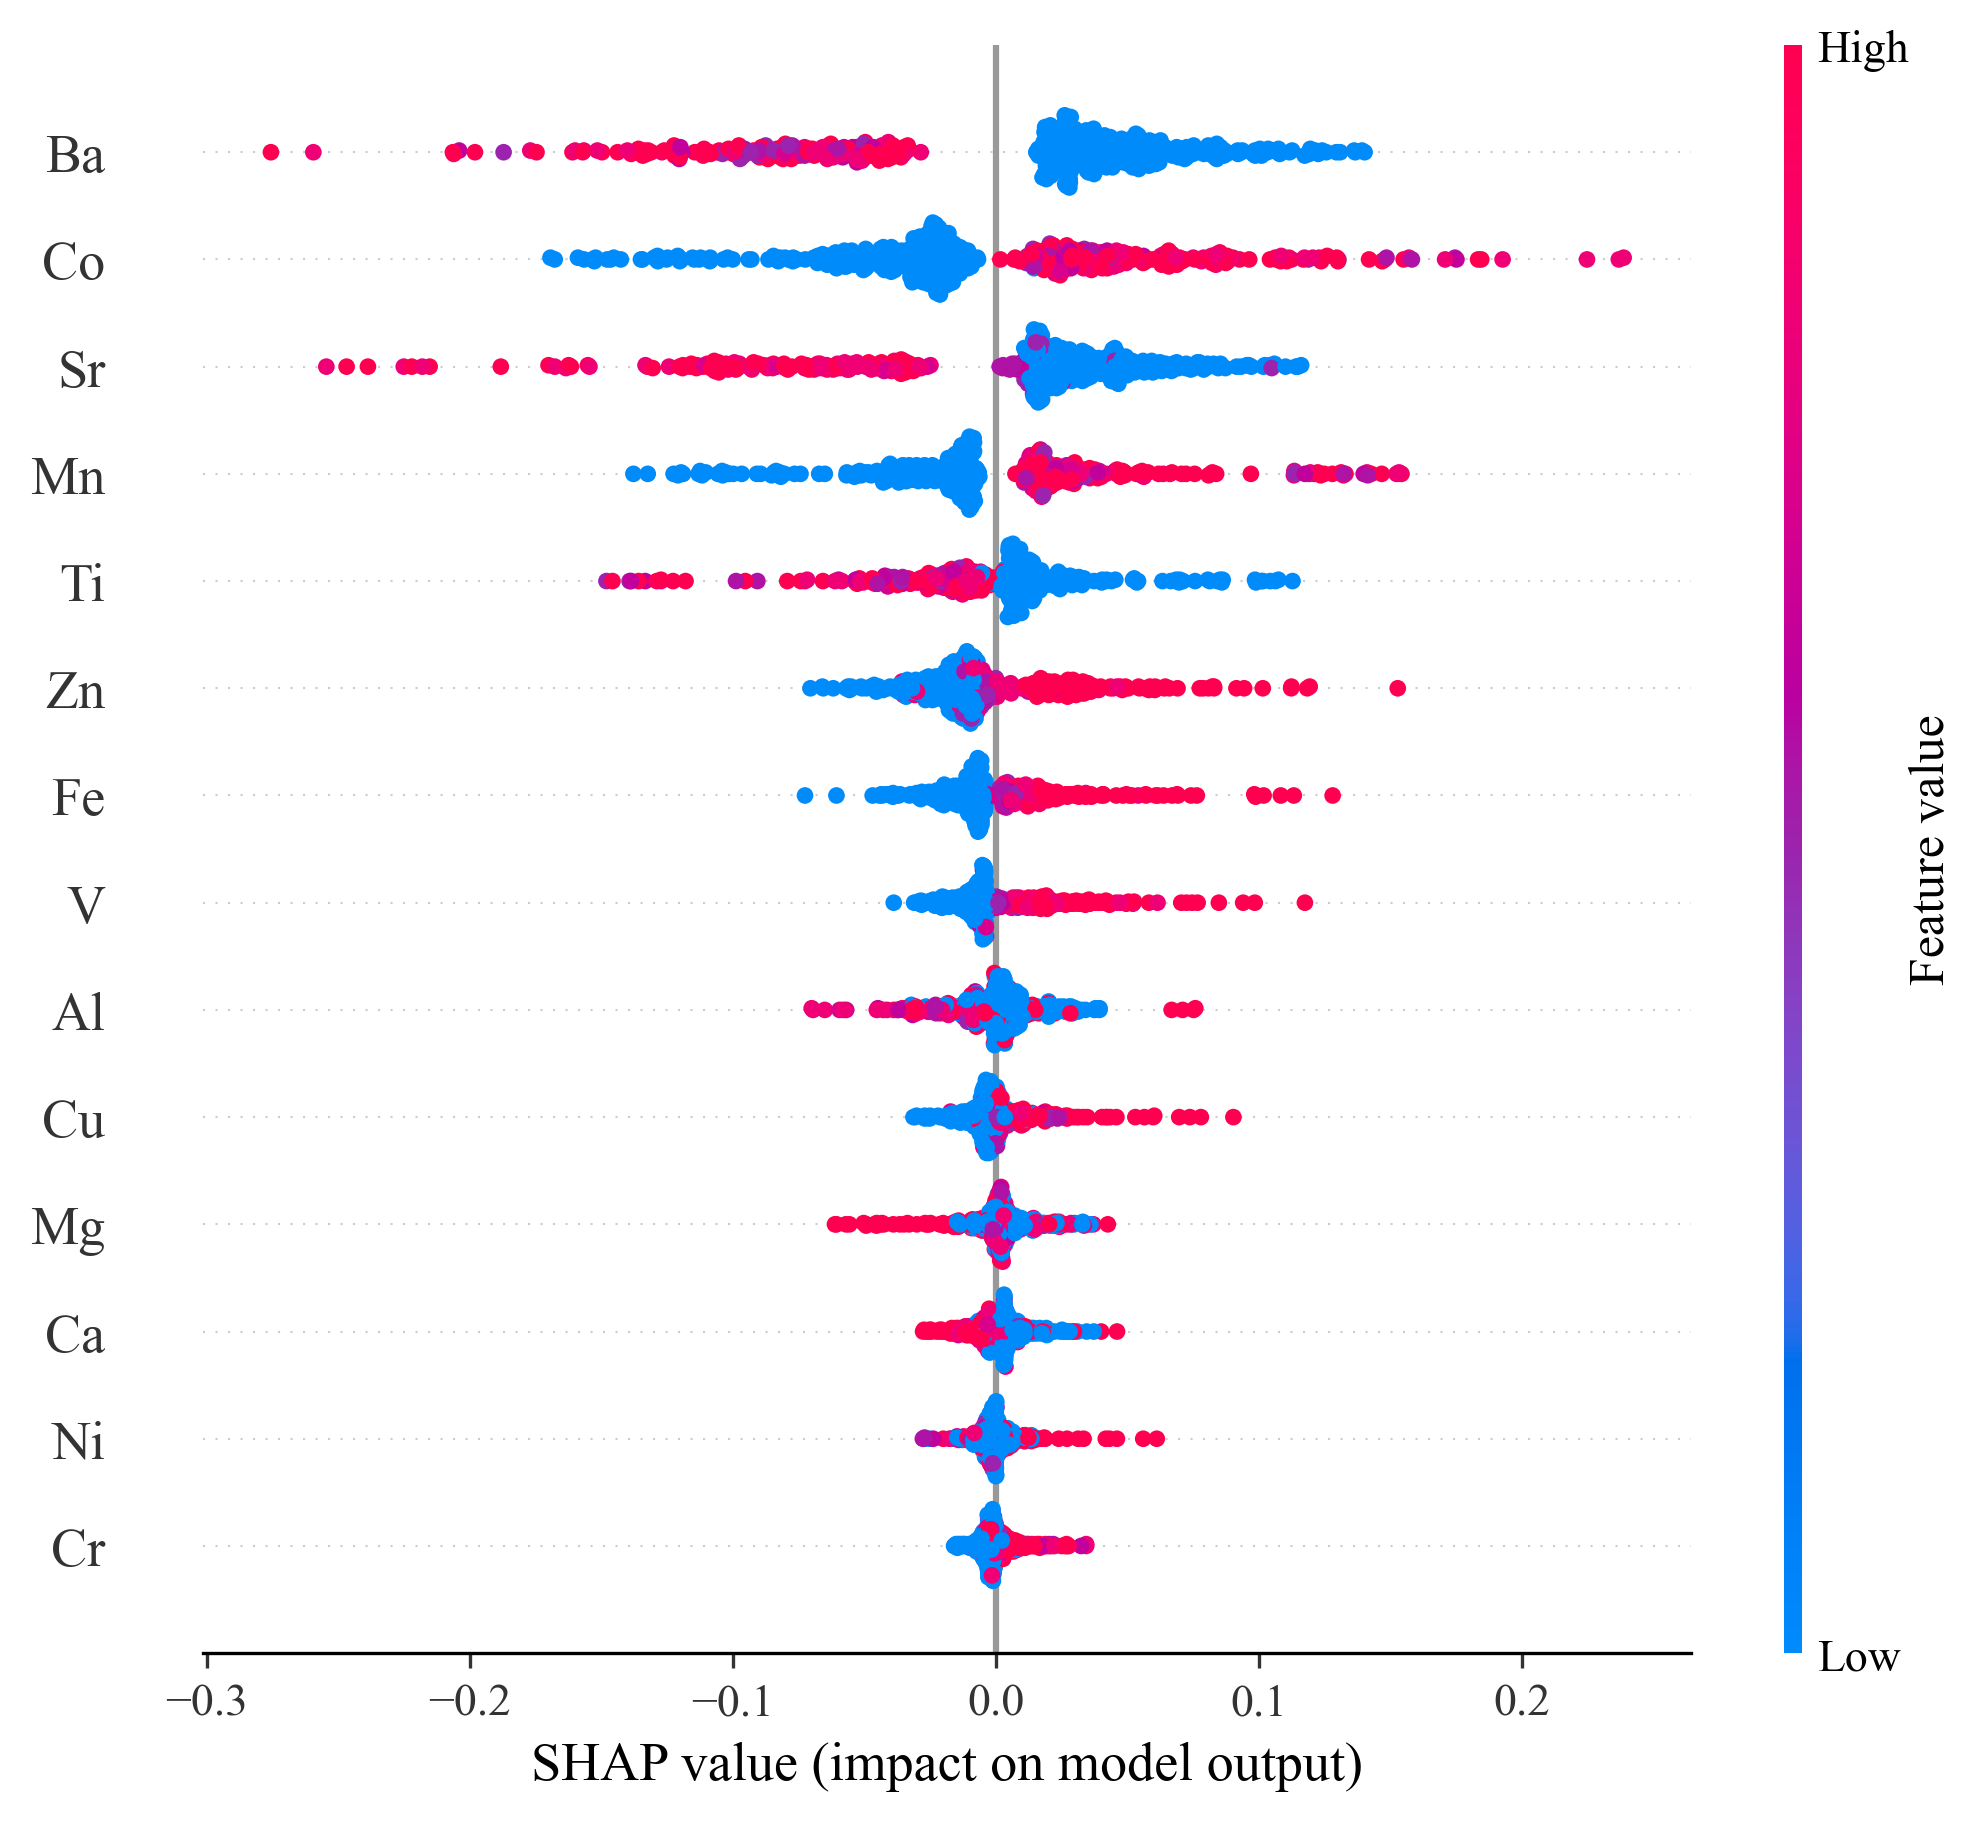

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
fs = 8
params = {'legend.fontsize': '%s' % (4. * fs),
          'figure.figsize': (fs * 1, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'savefig.dpi': 300,
          'figure.dpi': 300,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values[1], X, show=False)
    plt.savefig('figure_stable_shap.png')
    return explainer, shap_values
clf.fit(X, y)
explainer, shap_values = shap_ana(clf, X, y)

(array([44.5123576 ,  4.43480832,  3.1207926 ,  1.9710269 ,  1.31401761,
         1.97102678,  1.14976548,  0.82126111,  0.49275666,  0.6570088 ,
         1.31401794,  0.65700897,  0.49275648,  0.49275673,  0.16425224,
         0.16425224,  0.32850432,  0.16425216,  0.        ,  0.16425216,
         0.16425232,  0.16425216,  0.16425216,  0.        ,  0.65700864,
         0.        ,  0.16425216,  0.49275648,  0.        ,  0.        ,
         0.16425249,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16425216,  0.16425249,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.16425183,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.32850498]),
 array([-0.10225323, -0.08736766, -0.07248209, -0.05759652, -0.04271095,
        -0.02782538, -0.01293981,  0.00194576,  0.01683133,  0.03171689,
         0.04660247,  0.06148803,  0.0763736 ,  0.09125917,  0.10614474,
         0.12103031,  0.13591588,  0.15080145,  0

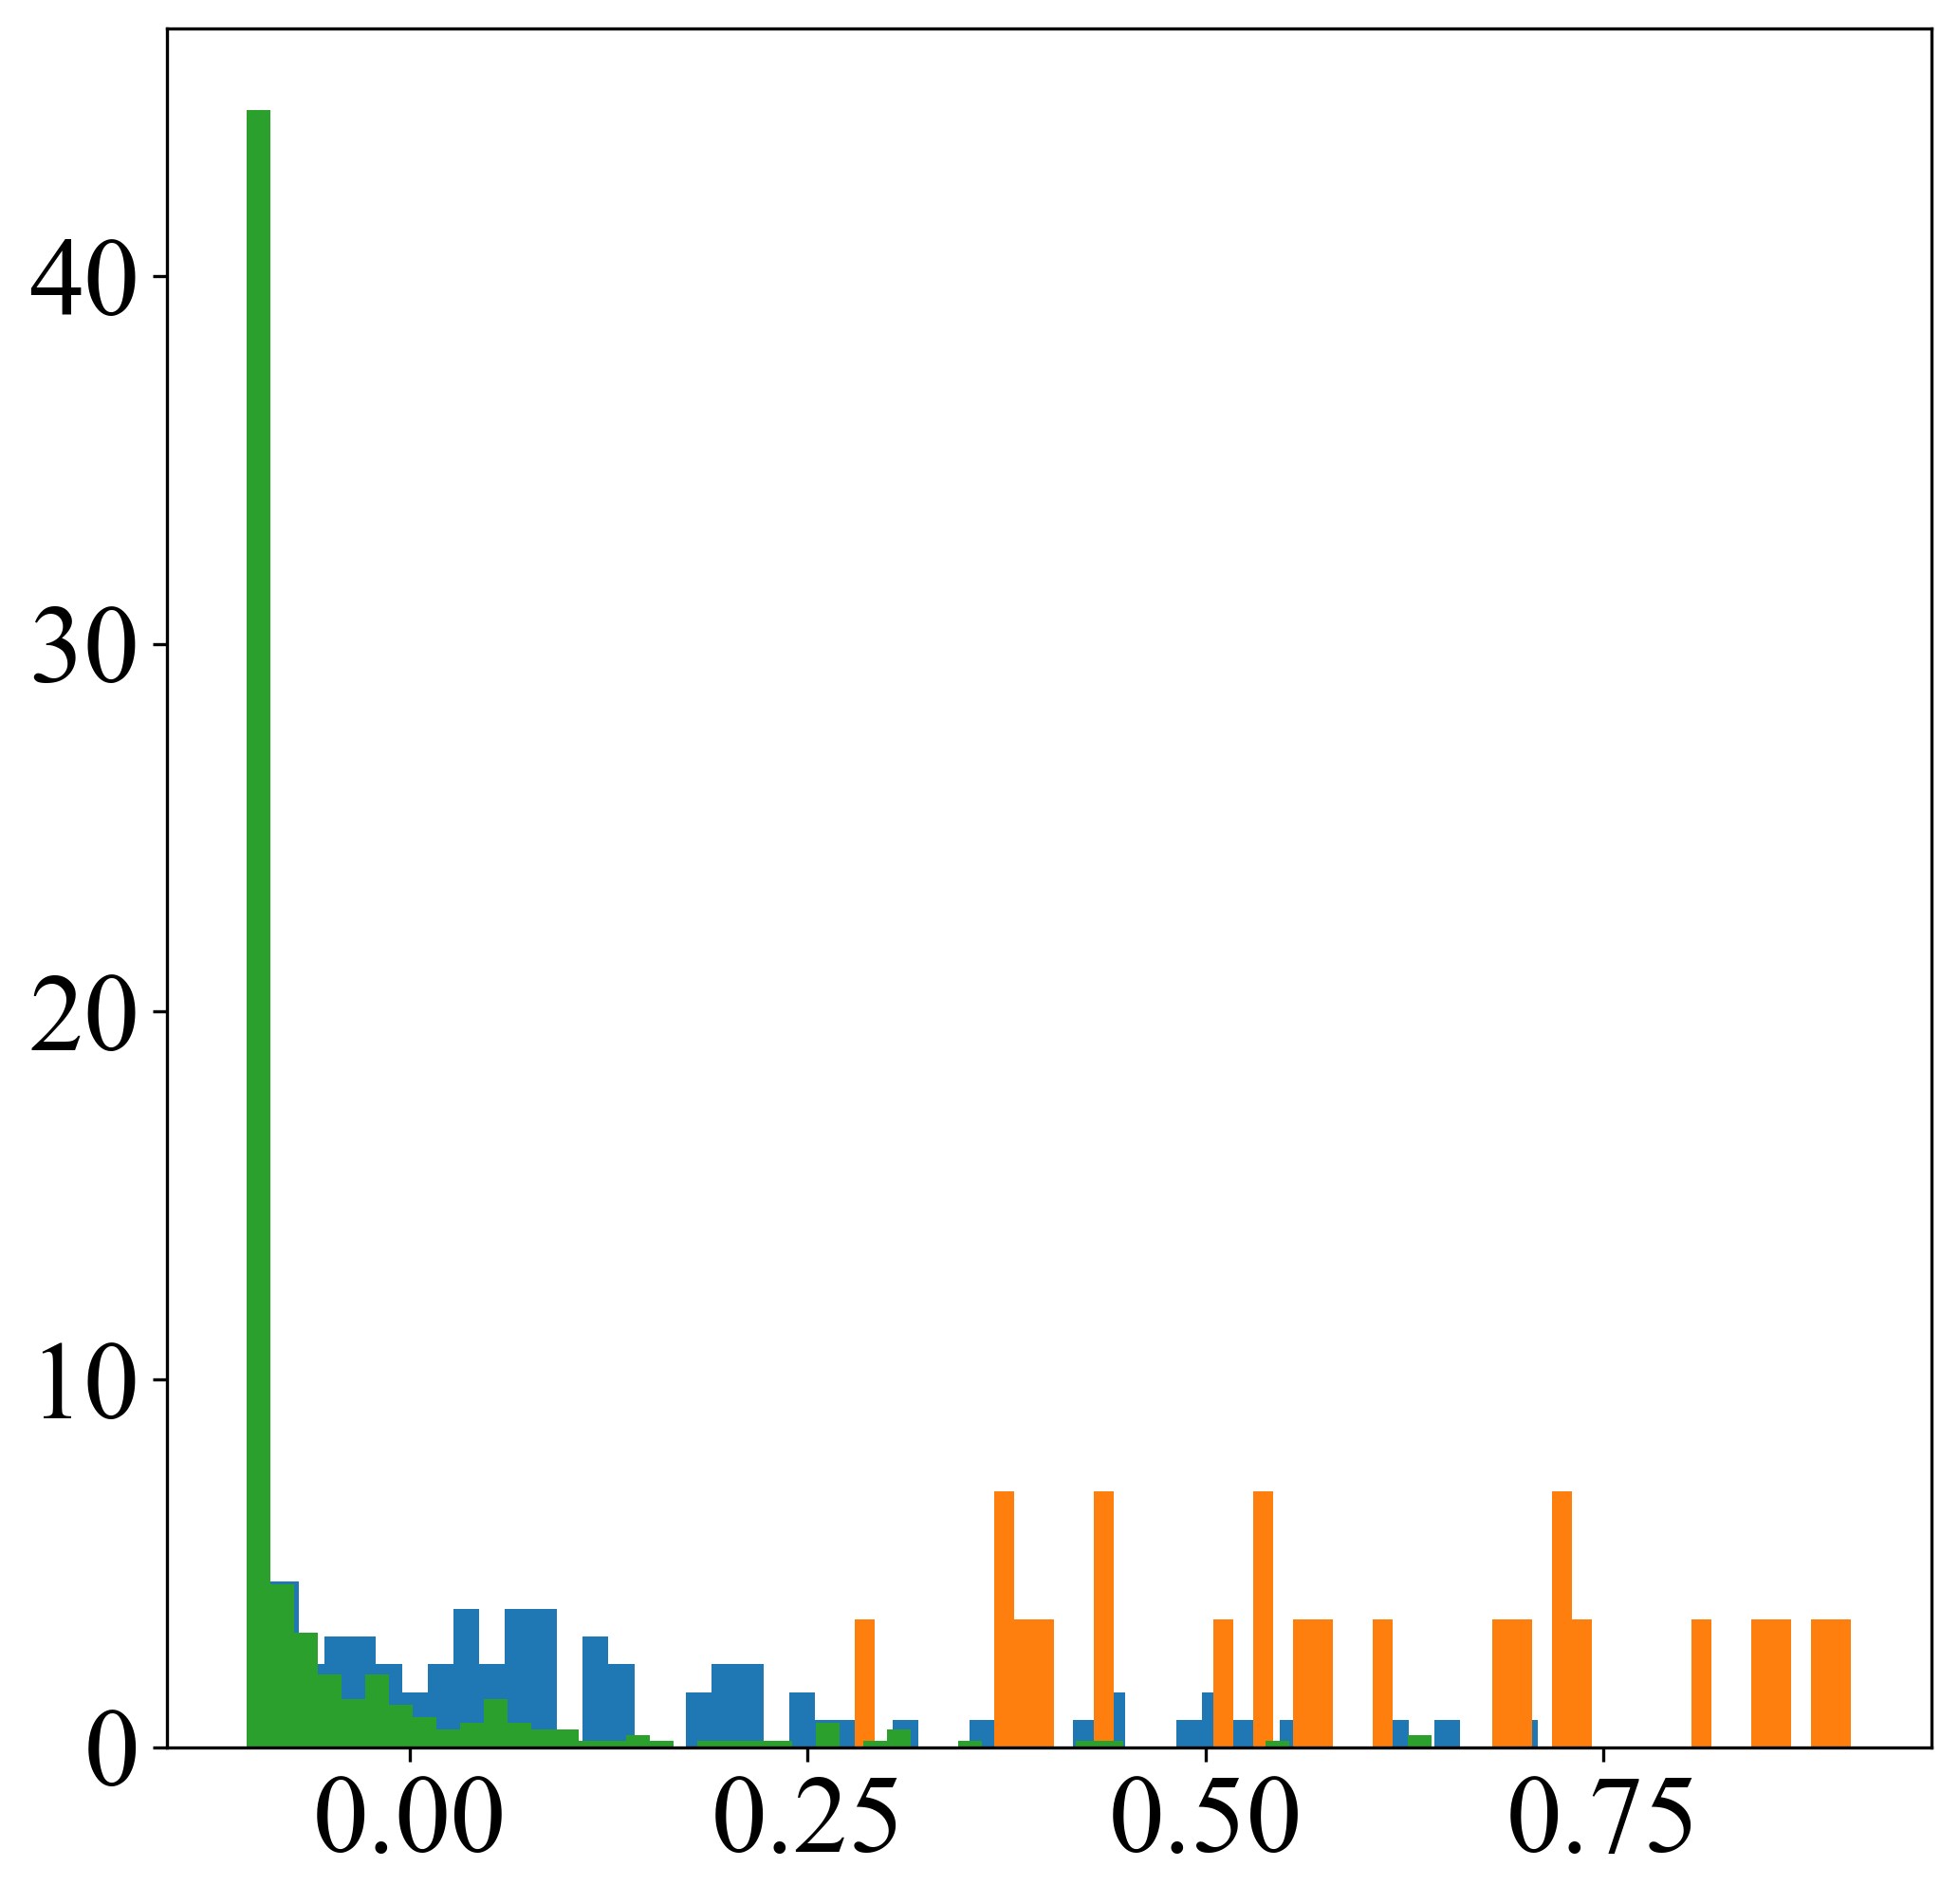

In [14]:
import matplotlib.pyplot as plt
plt.hist(shap_values[1][y == 2].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 0].sum(axis=1), bins=50, density=True)